# Code with explicit math imlpementation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os

In [3]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}
Lx, Ly = 12.5, 15.6
print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
print(tensor_.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]


Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:24<00:00,  8.27it/s]

(400, 320, 8, 200)
Data loading complete!


In [9]:
def select_rank_by_ratio(eigenvalues, threshold=0.1):
    eigenvalues = np.sort(eigenvalues)[::-1]
    ratios = eigenvalues / (eigenvalues[0] )
    return (ratios > threshold).sum()

In [11]:
start_t = time.time()
factors_st = []
current_tensor = tensor_combustion.copy()

for mode in range(current_tensor.ndim):
    unfolded = tl.unfold(current_tensor, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eig(g_matrix)
    trunc_idx = select_rank_by_ratio(eigenvalues, threshold=-1)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor = tl.tenalg.mode_dot(current_tensor, U_trunc.T, mode)
    factors_st.append(U_trunc)
core_st = current_tensor
print(factors_st)


400
320
8
200
[array([[-4.93853018e-02, -6.52913895e-02,  1.33512030e-03, ...,
         3.49026711e-05, -2.10208297e-05,  2.15729338e-05],
       [-4.93721380e-02, -6.52142398e-02,  1.34137619e-03, ...,
        -1.65112390e-04,  4.12648916e-04, -5.52389025e-04],
       [-4.93596021e-02, -6.51276895e-02,  1.35191439e-03, ...,
         2.11190687e-04, -2.36648290e-03,  3.57658847e-03],
       ...,
       [-5.00872642e-02,  6.74961060e-02, -5.40423975e-03, ...,
         4.03573498e-08, -6.66052453e-08, -8.38273052e-08],
       [-5.00844685e-02,  6.75293114e-02, -7.43046304e-03, ...,
        -1.03507766e-08,  5.27156176e-09,  6.11057121e-08],
       [-5.00839634e-02,  6.75821870e-02, -9.36515471e-03, ...,
        -1.84732587e-09,  7.60640901e-09, -2.62524075e-08]],
      shape=(400, 400)), array([[ 4.31487763e-05,  1.25509869e-03,  6.36644990e-02, ...,
        -1.54566630e-02, -1.54566630e-02,  1.61015845e-03],
       [ 4.31487763e-05,  1.25509869e-03,  6.36644990e-02, ...,
        -3.7770

In [13]:
reconstruction_st = tl.tenalg.multi_mode_dot(core_st, factors_st, [0,1,2,3])
print(np.allclose(reconstruction_st, tensor_combustion))


False


In [12]:
prova = []
for mode in range(tensor_combustion.ndim):
    unfolded = tl.unfold(tensor_combustion, mode)
    U, S, V = np.linalg.svd(unfolded, full_matrices=False)
    prova.append(U)
    break

In [17]:
print(np.allclose(np.abs(prova[0]), np.abs(factors_st[0])))

False


In [ ]:
def select_rank_by_ratio(eigenvalues, threshold=0.1):
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvalues = np.maximum(eigenvalues, 0)
    ratios = eigenvalues / (eigenvalues[0] + 1e-10)
    return (ratios > threshold).sum()


start_t = time.time()
factors_st = []
core_st = tensor_combustion.copy()

for mode in range(core_st.ndim):
    unfolded = tl.unfold(tensor_combustion, mode)  # usa sempre l'originale
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eig(g_matrix)
    
    idx = np.argsort(eigenvalues.real)[::-1]
    trunc_idx = select_rank_by_ratio(eigenvalues.real, threshold=0.000)
    
    U = eigenvectors[:, idx[:trunc_idx]].real
    factors_st.append(U)

# calcola il core con tutti i fattori
core_st = tl.tenalg.multi_mode_dot(tensor_combustion, [U.T for U in factors_st])
reconstruction_st = tl.tenalg.multi_mode_dot(core_st, factors_st)

end_t = time.time()
time_st = end_t - start_t
print(f"Total time st {time_st:.3f}")
print(np.allclose(reconstruction_st, tensor_combustion))


Total time st 10.626
False


In [ ]:
a = tl.unfold(tensor_combustion, 0)
gram = a@a.T
eigvals, eigvects = np.linalg.eigh(gram)
idx = np.argsort(eigvals)[::-1]  # descending order
eigvects = eigvects[:, idx]

U, S, V = np.linalg.svd(a, full_matrices=False)


(400, 512000)
(400, 400)
(400, 400)
(400, 400)


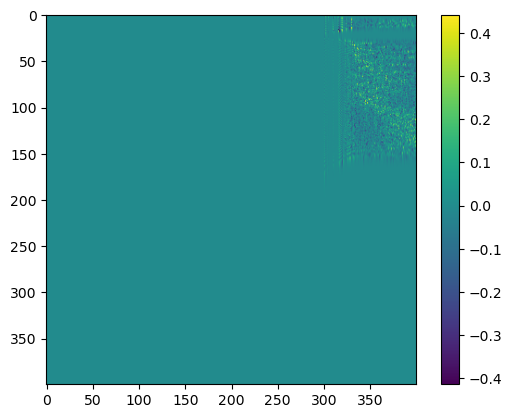

In [53]:
print(a.shape)
print(U.shape)
print(eigvects.shape)
print(gram.shape)
plt.imshow(np.subtract(np.abs(U), np.abs(eigvects)))
plt.colorbar()


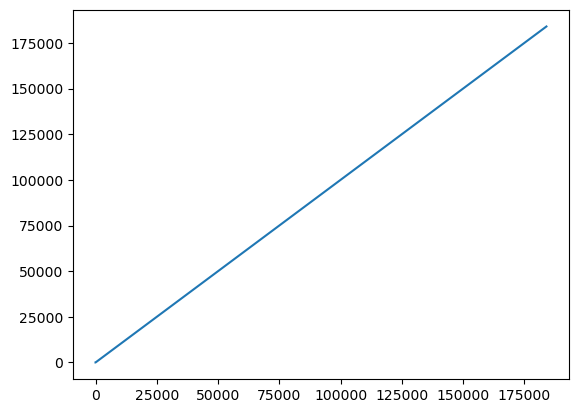

In [50]:
plt.plot(eigvals[::-1], S**2)